![](https://raw.githubusercontent.com/unm-escape/escape2022/main/header2.png)

<h1 style="text-align:center; color:#3333ff;">Plotting shot gathers from Rio Grande Experiment</h1>
<br>
<div style="text-align:center; font-size:16px">
    Earth and Planetary Sciences,<br>
    University of New Mexico<br>
    <br>
    August 14, 2023
</div>

---
**Tutorial Outline:**
1. Reading SEG-Y data from file<br>
2. Updating header info<br>
3. Applying simple amplitude attenuation correction<br>
4. Picking arrivals<br>
---
**Dependencies:** Obspy, Numpy, Matplotlib and the Utils script

---

<font size="4.5">**1. Reading SEG-Y data from file**</font><br>

In [41]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from obspy import Stream, read

from utils import pick_segy, plot_segy, plot_segy_picks, gain 

#### Let's just read a single shot from our experiment

In [42]:
stream = read('./SP24/24.SGY', format='SEGY',unpack_trace_headers=True)

print(stream)

24 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.999000Z | 1000.0 Hz, 1000 samples
...
(22 other traces)
...
Seq. No. in line:   24 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.999000Z | 1000.0 Hz, 1000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


#### Let's grab a trace object and view a summary its metadata.

In [43]:
tr = stream[11]
print(tr)


Seq. No. in line:   12 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.999000Z | 1000.0 Hz, 1000 samples


<pre>




</pre>

#### Let's view the actual data of the first trace

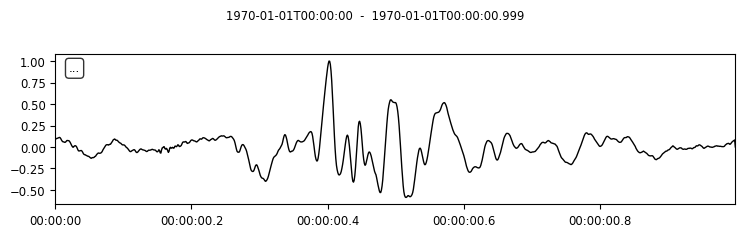

In [44]:
single_trace = tr.plot()

---
<font size="4.5">**2. Updating header info**</font><br>

The data is a **shot gather** with a time sampling rate of 0.001s and receiver spacing of 0.005 km (5 m). The shot location is at the end of the array at channel 24, near the field computer. 

The geometry information data isn't assigned, so let's update the receiver location, source location and the offset assuming a 2-D line.

In [45]:
sx = (len(stream)-1)*5 # source x coordinate

gx = sx # Initialize receiver 1 x coordinate at 0 m

# Loop throught the stream
for tr in stream:
    tr.stats.segy.trace_header.group_coordinate_x = gx
    tr.stats.segy.trace_header.source_coordinate_x = sx
    tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group = gx-sx
    gx -= 5

print("Update done!")

Update done!


In [46]:
tr = stream[0]

print(tr.stats.segy.trace_header.group_coordinate_x)

115


---
<font size="4.5">**3. Applying simple amplitude attenuation correction**</font><br>

Seismic amplitude is the magnitude of the wiggles in a seismic record. The amplitude of seismic data depends on the source, receiver, and the medium in which the waves are propagating.

In active source reflection seismology, we account for seismic wave amplitude loss due to transmission, absorption and spherical spreading by applying offset and time dependent gain.

#### Let's plot the raw shot gather with the plot_segy function:

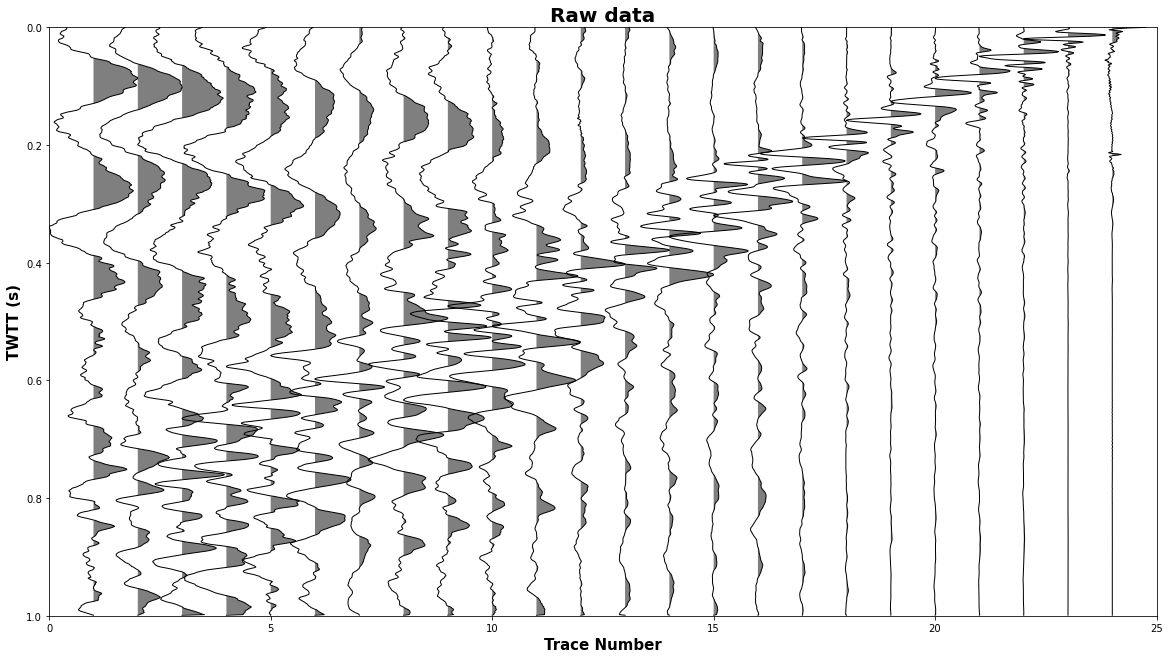

In [47]:
## Plot raw traces
startTime = 0.0
endTime = 1
plot_segy(stream, normalizeGlobal=True, 
          scale=1, title='Raw data', tstart=startTime, tend=endTime, saveFigure=False)

---
#### This plot shows the raw data without any gain applied.

**Gain** is amplitude correction applied to the seismic data. There are data-independent and data-dependent amplitude correction methods. In data-independent techniques, the scaling function is not derived from the amplitude information in the data.

An example of a data-independent method is the $t^{2}$ method where each trace's data is multiplied by the square of the two-way travel time (Yilmaz, 2001).

Use the gain function from the Util module to apply the $t^{2}$ gain:

---

In [48]:
gainedStream = gain(stream, normalizeTraces=False)



Use the plot_segy function from the Util module to plot the $t^{2}$ gained dataset.

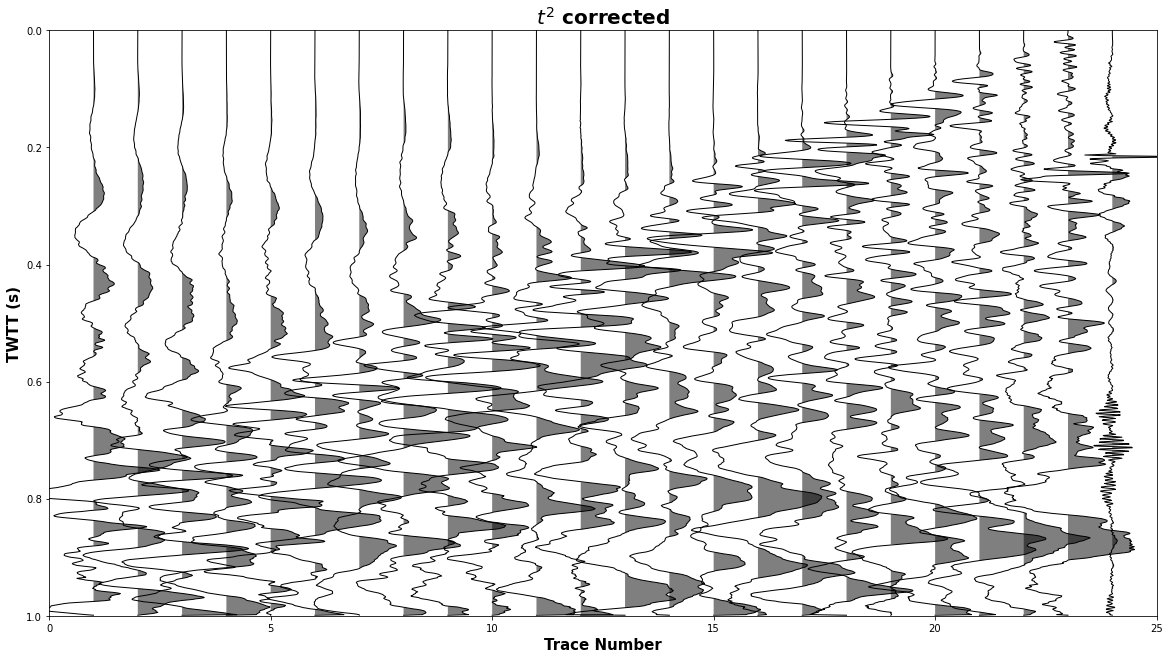

In [49]:
startTime = 0
endTime = 1
plot_segy(gainedStream, scale=1.5, title='$t^{2}$ corrected', normalizeTraces=True,
          tstart=startTime, tend=endTime, saveFigure=False)

#### Looks noisy, luckily we collected 10 shots for every shot point. We can combine them by "stacking".  

***Before we get into stacking the whole data gather, let's just get a feel for what the stacking does by looking at the changes in one trace when we average multiple traces together.***

In [50]:
#Start by reading in multiple segy files into separate streams--
## ...btw, I bet you could think of a better way to do this!!:

st1 = read('./SP24/15.SGY', format='SEGY',check_compression=False,unpack_trace_headers=True)
st2 = read('./SP24/16.SGY', format='SEGY',check_compression=False,unpack_trace_headers=True)
st3 = read('./SP24/17.SGY', format='SEGY',check_compression=False,unpack_trace_headers=True)
st4 = read('./SP24/18.SGY', format='SEGY',check_compression=False,unpack_trace_headers=True)




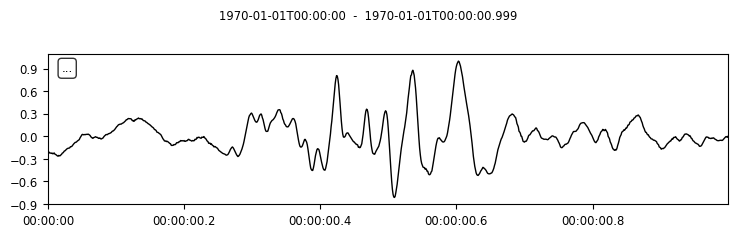

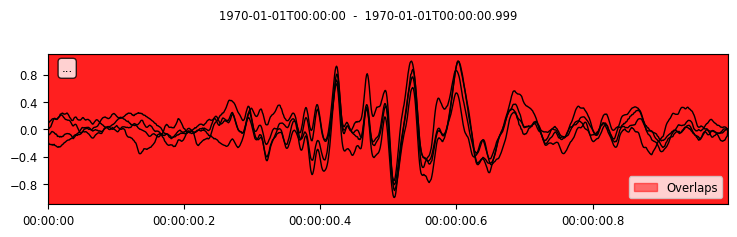

In [53]:
# We can then pull one trace from each stream -- remember each stream (data file) has 24 channels, 
# one for each geophone. The traces are indexed, we can used 0 for the nearest trace or 23 for the farthest.
# use whichever index you want. 

trace1 = st1.traces[10]
trace2 = st2.traces[10]
trace3 = st3.traces[10]
trace4 = st4.traces[10]

#plot one of the traces
one_trace = trace1.plot()

#combine these traces into one stream -- this new stream will have 4 traces:
new_st = Stream(traces=[trace1, trace2, trace3, trace4])

# and plot all of the traces....what do you notice?
new_st_plot = new_st.plot()

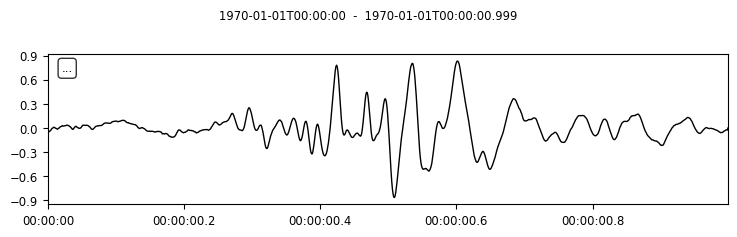

In [52]:
# now, we can stack the traces
stack = new_st.stack()

# and plot:
plot_stack = stack.plot()

**Now that we have a feel for it, we'll stack all the traces. This script is a bit more complicated. We're loading all the shots, grabbing individual channels, then averaging them.

Also, bet that you thought of a smarter way to extract the traces above....that's right, a for loop!** 

In [10]:
import os
import obspy

# Directory to SEG-Y files
data_directory = './SP24'

# Get a list of all SEG-Y files in the directory -- this will help with the for loop.
segy_files = [f for f in os.listdir(data_directory) if f.endswith('.SGY')]

# Create a dictionary to store stacked traces for each source/receiver offset
stacked_offsets = {}

# Loop through each SEG-Y file and stack by source receiver offset

for segy_file in segy_files:
    stream = read(os.path.join(data_directory,segy_file), format='SEGY', unpack_trace_headers=True)
    gainedStream = gain(stream, normalizeTraces=False)

    sx = (len(stream)-1)*5 # source x coordinate
    gx = sx # receiver 1 x coordinate at 0 m

    # Loop through the stream
    for tr in gainedStream:
        tr.stats.segy.trace_header.group_coordinate_x = gx
        tr.stats.segy.trace_header.source_coordinate_x = sx
        tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group = gx-sx
        gx -= 5
        
        offset = tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group
        if offset not in stacked_offsets:
            stacked_offsets[offset] = [tr]
        else:
            stacked_offsets[offset].append(tr)
            
# Create an empty stream object           
stacked_stream = obspy.Stream()    

# Loop through stacked offsets and calculate the average trace
for offset, traces in stacked_offsets.items():
    stacked_data = np.mean(traces, axis=0)
    
    # Create a new Trace object with the stacked data
    stacked_trace = obspy.Trace(data=stacked_data)
    stacked_trace.stats.segy = traces[0].stats.segy
    stacked_trace.stats.sampling_rate = traces[0].stats.sampling_rate
    stacked_stream.append(stacked_trace)
    




---
<font size="4.5">**4. Picking arrivals**</font><br>
<br>

![](https://raw.githubusercontent.com/unm-escape/escape2022/main/day08_Aug17/schematic.png)

Now we identify the phases and pick the arrivals.

First let's isolate one half of the raw and gained shot gather.

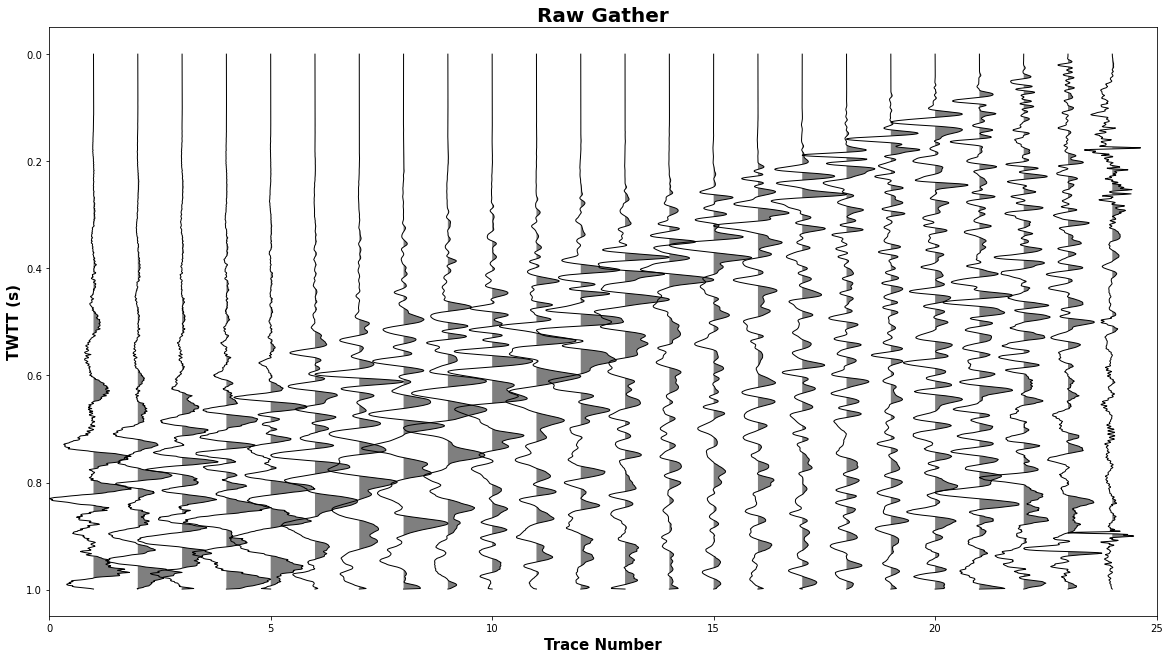

In [11]:
plot_segy(stacked_stream, scale=1, title='Raw Gather', normalizeTraces=True, saveFigure=False)

#### Looks great! Now we can ask, is the ground along our profile satured? Saturated sediments have P-wave velocities on the order of ~1500 m/s

1) Solve this question by picking the first arrival. 
2) You'll probably want to do this twice to estimate the velocities of a shallow layer and a deeper layer. 

In [12]:
## Pick first arrival
startTime = 0.0
endTime = 1.0
dw_trc_nums, dw_picks, dw_offsets = pick_segy(stacked_stream, normalizeTraces=True, normalizeGlobal=False, scale=1.5, 
                                          title=None, tstart=startTime, tend=endTime, 
                                          saveFigure=False)

Success! Picks Ready.


---
#### Pick_segy outputs three list variables
1) dw_tr_nums - list of pick trace numbers
2) dw_picks   - list of time picks
3) dw_offets  - list of offset distance between the picked trace and source
---


In [13]:
print('Picked channels are', dw_trc_nums, '\n')
print('Picked times are', np.round(dw_picks,4), 'seconds \n')
print('Picked offsets are', dw_offsets, 'meters')

Picked channels are [ 22.  21.  20.  19.  18.  17.  16.  15.  14.  13.  12.  11.  10.   9.   8.
   7.   6.   5.   4.   3.] 

Picked times are [ 0.02    0.0331  0.0512  0.0725  0.1037  0.13    0.1726  0.2022  0.2235
  0.2399  0.2514  0.2629  0.2777  0.2924  0.3088  0.317   0.3302  0.3564
  0.3646  0.3892] seconds 

Picked offsets are [-105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10] meters


#### Plot the picks on the half-offset gathers

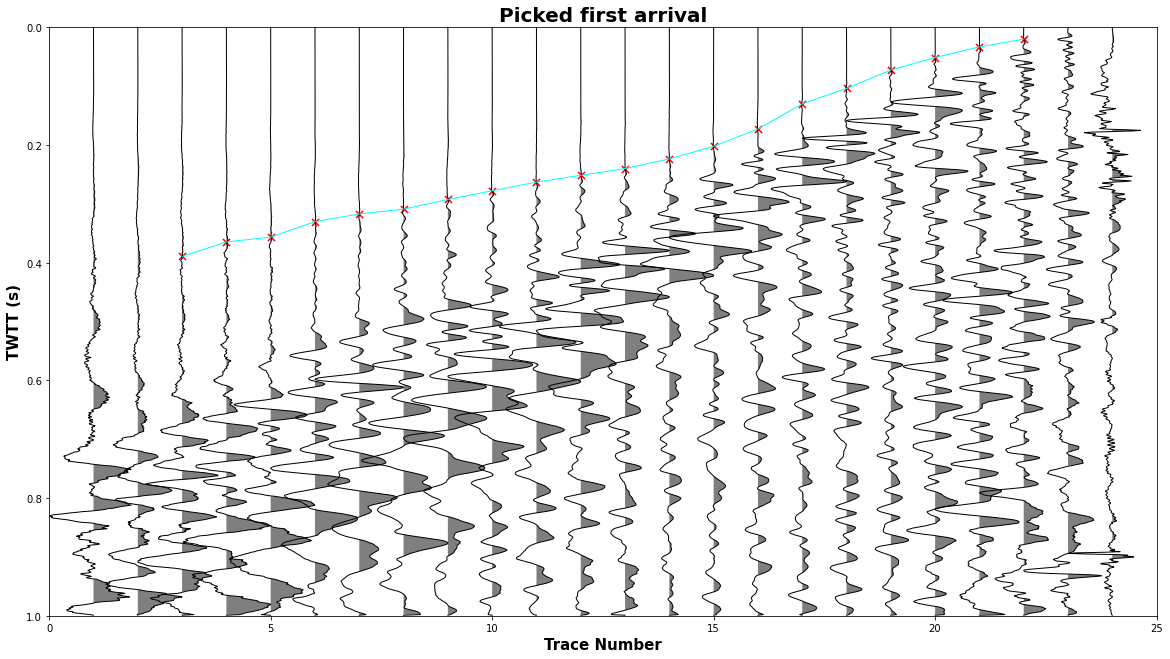

In [14]:
## Plot picks
%matplotlib inline
plot_segy_picks(stacked_stream, normalizeTraces=True, normalizeGlobal=False, scale=1, title='Picked first arrival', 
                tstart=0, tend=1, picksX=dw_trc_nums, picksY=dw_picks, saveFigure=True)

#### Create a T-X plot with your picks. 
By fitting a line to our first arrival, we create a very simple **model** for the average P-wave velocity along the fastest path. <br>

The function ***np.polyfit(x,t,1)*** takes two numerical lists and finds a linear function of best-fit. <br>

We can then use ***np.poly1d()*** to calculate a function for calculating lines of best-fit.

In [15]:
# Estimate model from picks and offsets
coeffs = np.polyfit(dw_offsets,dw_picks,1)
print(coeffs, 'correspond to the slope (seconds/meter) and t-intercept (seconds)')


# Create the poly1d_fn function which takes in x and returns an estimate for y
poly1d_fn = np.poly1d(coeffs)


[ 0.00389166  0.44374104] correspond to the slope (seconds/meter) and t-intercept (seconds)


<pre>




</pre>
#### Plot the model and picks

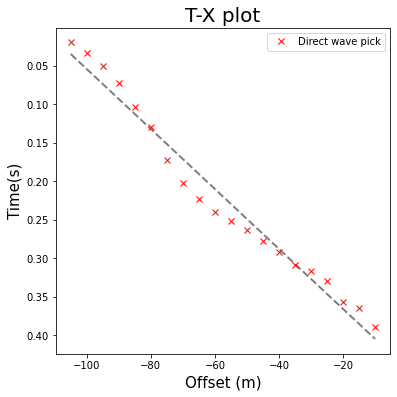

In [16]:
fig, axs = plt.subplots(figsize=(6,6))
plt.axis('off')

ax = fig.add_subplot()
ax.plot(dw_offsets, dw_picks, 'rx', label='Direct wave pick')
ax.plot(dw_offsets, poly1d_fn(dw_offsets), '--k', lw=2.0, zorder=1, alpha=0.5)

ax.set_xlabel('Offset (m)', fontsize=15)
ax.set_ylabel('Time(s)', fontsize=15)
plt.title('T-X plot', fontsize=20)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

<pre>




</pre>
#### Use Numpy's polyfit function to calculate $V_{0}$

**t = mx + b**


In [17]:

m, b = np.polyfit(dw_offsets, dw_picks, 1)

print('V\N{SUBSCRIPT ZERO} = ' + str(round(1/m, 0)) + ' m/s')

V₀ = 257.0 m/s


<pre>




</pre>

#### Use the pick_segy function to pick the first strong reflected wave - same procedure as the first arrival.